In [1]:
from __future__ import print_function

import torch
import torch.optim as optim

from torch.utils.data.dataset import Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.backends.cudnn.bencmark = True
import torchvision
import torchvision.transforms as transforms

import os,sys,cv2,random,datetime,time,math
import argparse
import numpy as np

from net_s3fd import *
from s3fd import *
from bbox import *
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

In [2]:
class CelebDataset(Dataset):
    """Dataset wrapping images and target labels
    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['Image_Name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['Image_Name']
        self.y_train = self.mlb.fit_transform(tmp_df['Gender'].str.split()).astype(np.float32)
    def __getitem__(self, index):
        img = cv2.imread(self.img_path + self.X_train[index] + self.img_ext)
        img = cv2.resize(img, (256,256))
        img = img - np.array([104,117,123])
        img = img.transpose(2, 0, 1)
        
        #img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        #img = Variable(torch.from_numpy(img).float(),volatile=True)
        
        #if self.transform is not None:
        #    img = self.transform(img)
        
        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train.index)

In [3]:
transformations = transforms.Compose(
    [
     transforms.ToTensor()
     
     #transforms.Normalize(mean=[104,117,123])
     ])

In [4]:
train_data = "index.csv"
img_path = "data/Celeb_Small_Dataset/"
img_ext = ".jpg"
dset = CelebDataset(train_data,img_path,img_ext,transformations)
train_loader = DataLoader(dset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
tensor([ 1.,  0.])
torch.Size([2])
torch.Size([23, 2])
tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]])
(256, 256, 3)


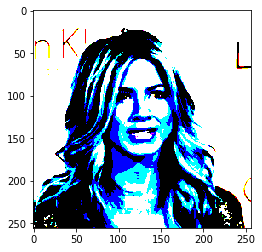

In [5]:
## bad data visualization, perhaps need to change from BGR to RGB
fig = plt.figure()
for i in range(len(dset)):
    sample = dset[0]
    print(i)
    print(sample[1])
    image = sample[0]
    tensor_result = sample[1]
    print(sample[1].size())
    tensor_result = tensor_result.unsqueeze(0)
#     tensor_result = tensor_result.unsqueeze(2)
#     tensor_result = tensor_result.unsqueeze(3)
    tensor_result = tensor_result.expand(23,2)
    print(tensor_result.size())
    print(tensor_result)
#     tensor_repeated = tensor_result.
    image_changed = image.permute(1,2,0)
    print(image_changed.numpy().shape)
#     print(image.transpose().shape)
#     image_changed = [image[1], image[2], image[0]]
    plt.imshow(image_changed)
    break

In [6]:
def save(model, optimizer, loss, filename):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.data[0]
        }
    torch.save(save_dict, filename)

In [11]:
def train_model(model, criterion, optimizer, num_classes, num_epochs = 100):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        model.train()
        running_loss = 0.0

        for i,(img,label) in enumerate(train_loader):
            img = img.view((1,)+img.shape[1:])
            if use_cuda:
                data, target = Variable(img.cuda()), Variable(torch.Tensor(label).cuda())
            else:
                data, target = Variable(img), Variable(torch.Tensor(label))
            target = target.view(1, num_classes)

            optimizer.zero_grad()
            gender_classifications = model(data, use_cuda)
#             for gender_classification in gender_classifications:
#                 FB, FC, FH, FW = gender_classification.size()
#                 tensor_target = target.unsqueeze(2)
#                 tensor_target = tensor_target.unsqueeze(3)
#                 tensor_target = tensor_target.expand(1, num_classes, FH, FW)
#                 assert(gender_classification.size() == tensor_target.size())
#                 loss = criterion(gender_classification, tensor_target)
#                 running_loss += loss.item()
#                 loss.backward()
            tensor_target = target.expand(gender_classifications.size()[0], num_classes)
            loss = criterion(gender_classifications, tensor_target)
            print(loss.item())
            loss.backward()
                        
            
            for name, parameter in myModel.named_parameters():
                if parameter.grad is not None:
                    print(name)
                    print(parameter.grad)

            
            optimizer.step()
        
        print("Loss = ", running_loss)
        print('-' * 10)

        if epoch % 10 == 0:
            save(model, optimizer, loss, 'faceRecog.saved.model')
        


In [8]:
# initialize the new model
num_classes = 2
myModel = s3fd_original()

# load pre trained weights
loadedModel = torch.load('s3fd_convert.pth')
newModel = myModel.state_dict()

# compute intersection
pretrained_dict = {k: v for k, v in loadedModel.items() if k in newModel}

# update newModel dictionary
newModel.update(pretrained_dict)
#update the pytorch model
myModel.load_state_dict(newModel)

# freeze all layers
for param in myModel.parameters():
    param.requires_grad = False

# unfreeze gender layer weights and biases

myModel.conv4_3_norm_gender.weight.requires_grad = True
myModel.conv4_3_norm_gender.bias.requires_grad = True

myModel.conv5_3_norm_gender.weight.requires_grad = True
myModel.conv5_3_norm_gender.bias.requires_grad = True

myModel.conv6_2_gender.weight.requires_grad = True
myModel.conv6_2_gender.bias.requires_grad = True

myModel.fc7_gender.weight.requires_grad = True
myModel.fc7_gender.bias.requires_grad = True

# now lets initialize the new layers with the face weights from previous layers

conv4_3_tensor = myModel.conv4_3_norm_mbox_conf.weight[0]
conv4_3_tensor.unsqueeze_(0)
conv_4_3_gen_weights = torch.cat((conv4_3_tensor, conv4_3_tensor), 0)
myModel.conv4_3_norm_gender.weight = torch.nn.Parameter(conv_4_3_gen_weights)
# torch.nn.init.xavier_uniform_(myModel.conv4_3_norm_gender.weight)


conv5_3_tensor = myModel.conv5_3_norm_mbox_conf.weight[0]
conv5_3_tensor.unsqueeze_(0)
conv_5_3_gen_weights = torch.cat((conv5_3_tensor, conv5_3_tensor), 0)
myModel.conv5_3_norm_gender.weight = torch.nn.Parameter(conv_5_3_gen_weights)
# torch.nn.init.xavier_uniform_(myModel.conv5_3_norm_gender.weight)


fc7_tensor = myModel.fc7_mbox_conf.weight[0]
fc7_tensor.unsqueeze_(0)
fc7_gen_weights = torch.cat((fc7_tensor, fc7_tensor), 0)
myModel.fc7_gender.weight = torch.nn.Parameter(fc7_gen_weights)
# torch.nn.init.xavier_uniform_(myModel.fc7_gender.weight)

conv6_2_tensor = myModel.conv6_2_mbox_conf.weight[0].unsqueeze_(0)
myModel.conv6_2_gender.weight = torch.nn.Parameter(torch.cat((conv6_2_tensor, conv6_2_tensor), 0))
# torch.nn.init.xavier_uniform_(myModel.conv6_2_gender.weight)





In [9]:
use_cuda = True
myModel.eval()

s3fd_original(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d

In [10]:
criterion = nn.BCELoss()
# turn off gradient update for old layers
# for param in myModel.parameters():
#     param.requires_grad = False
# myModel.conv3_3_norm_gender.weight.requires_grad = True
# myModel.conv3_3_norm_gender.bias.requires_grad = True

# myModel.fc_1 = nn.Linear(2304,num_classes)
# for parameter in myModel.parameters():
#     print(parameter.requires_grad)
optimizer = optim.SGD(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.001, momentum=0.9)
if use_cuda:
    print("using cuda")
    myModel = myModel.cuda()
model_ft = train_model(myModel, criterion, optimizer, num_classes, num_epochs=100)

using cuda
Epoch 1/100
0.6929264664649963
0.6970528364181519
0.689474880695343
0.6951481699943542
0.688607394695282
0.6983307003974915
0.6884839534759521
0.6983307003974915
0.6972271800041199
0.6926637291908264
0.6934364438056946
0.6929264664649963
0.6922212839126587
0.6960101127624512
0.6913558840751648
0.6936051845550537
0.6983306407928467
0.694133460521698
0.6937337517738342
0.693487823009491
0.691192090511322
0.6983305811882019
0.697269856929779
0.6946178078651428
0.6942802667617798
0.6946178078651428
0.6949552893638611
0.6922212839126587
0.6915314793586731
0.697269856929779
0.6879903078079224
0.692702054977417
0.6967673897743225
0.6983306407928467
0.6947115063667297
0.6983307003974915
0.6915866136550903
0.6983306407928467
0.6935039162635803
0.6932499408721924
0.6983307003974915
0.6923691034317017
0.693487823009491
0.6969555020332336
0.6912810802459717
0.6929841637611389
0.6946178674697876
0.697269856929779
0.6973159313201904
0.6927614212036133
0.6879903674125671
0.6879903078079224

/home/parth/anaconda2/envs/deep_learning/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0.6940315365791321
0.6983307003974915
0.6940315365791321
0.6983307003974915
0.6937623620033264
0.697269856929779
0.6950394511222839
0.6983306407928467
0.6905921697616577
0.688607394695282
0.6970528364181519
0.6983307003974915
0.6940873861312866
0.6968353986740112
0.6913558840751648
0.6929841637611389
0.6879903674125671
0.6882489323616028
0.6923655271530151
0.6942464709281921
0.6916924118995667
0.6932499408721924
0.6983306407928467
0.6983306407928467
0.6971805691719055
0.693487823009491
0.6983306407928467
0.6975489854812622
0.693487823009491
0.694512665271759
0.6968496441841125
0.6948131918907166
0.6936051845550537
0.6934753656387329
0.6929264068603516
0.6983307003974915
0.6946178078651428
0.6983306407928467
0.693942666053772
0.6960101127624512
0.6983306407928467
0.6884839534759521
0.6949552893638611
0.6944563388824463
0.6944223642349243
0.6937337517738342
0.6922382116317749
0.6937501430511475
0.6983306407928467
0.6940873861312866
0.6935039162635803
0.6946178078651428
0.6920165419578552

Process Process-2:
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/parth/anaconda2/envs/deep_learning/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/parth/anaconda2/envs/deep_learning/lib/py

0.6934225559234619


KeyboardInterrupt: 

In [ ]:
len(list(filter(lambda p: p.requires_grad,myModel.parameters())))

In [ ]:
def transform(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256,256))
        img = img - np.array([104,117,123])
        img = img.transpose(2, 0, 1)
        
        img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        
        return Variable(img.cuda())
myModel = myModel.cuda()
testImage1 = transform('data/Test/TestCeleb_4/25-FaceId-0.jpg')
testImage2 = transform('data/Test/TestCeleb_4/26-FaceId-0.jpg')
testImage3 = transform('data/Test/TestCeleb_4/27-FaceId-0.jpg')
testImage4 = transform('data/Test/TestCeleb_10/25-FaceId-0.jpg')
testImage5 = transform('data/Test/TestCeleb_10/26-FaceId-0.jpg')
testImage6 = transform('data/Test/TestCeleb_10/24-FaceId-0.jpg')

output1 = myModel(testImage1)
output2 = myModel(testImage2)
output3 = myModel(testImage2)
output4 = myModel(testImage4)
output5 = myModel(testImage5)
output6 = myModel(testImage6)
print("testImage1 - ",output1)
print("testImage2 - ",output2)
print("testImage3 - ",output3)
print("testImage1 - ",output4)
print("testImage2 - ",output5)
print("testImage3 - ",output6)

In [ ]:
for parameter in myModel.parameters():
    print(parameter.requires_grad)